<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/time_series_forecasting/4_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*#author: Caroline Jungheim*

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import os

context_window = 336
prediction_horizon = 96

#🦋 Add both variables temperature and ozone data
variable_column = ["temp", "o3"]
#🦋 Specify target variable
target_variable = ["o3"]

In [95]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

## Download the .pkl files from drive

In [96]:
#🦋 Get Google Drive Path
from google.colab import drive
drive.mount('/content/drive')
BASEPATH = '/content/drive/MyDrive'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [97]:
#🦋 Get data from saved csv
dataframe = pd.read_csv(os.path.join(BASEPATH + "/content/timeseries_data", "normalized_data.csv"))

dataframe.head()

,longitude,latitude,station_code,datetime,o3,no2,no,temp,press
0,6.093923,50.754704,DENW094,1997-01-01 00:00:00+00:00,-1.686509,-2.140763,-0.758096,-3.566220,-337.675195
1,6.093923,50.754704,DENW094,1997-01-01 01:00:00+00:00,-1.686509,-2.140763,-0.758096,-3.633418,-337.675195
2,6.093923,50.754704,DENW094,1997-01-01 02:00:00+00:00,-1.686509,-2.140763,-0.758096,-3.646857,-337.675195
3,6.093923,50.754704,DENW094,1997-01-01 03:00:00+00:00,-1.686509,-2.140763,-0.758096,-3.740934,-337.675195
4,6.093923,50.754704,DENW094,1997-01-01 04:00:00+00:00,-1.686509,-2.140763,-0.758096,-3.767813,-337.675195


In [98]:
dataframe = dataframe.drop(columns=["no2","no","press"])
dataframe.head()

,longitude,latitude,station_code,datetime,o3,temp
0,6.093923,50.754704,DENW094,1997-01-01 00:00:00+00:00,-1.686509,-3.566220
1,6.093923,50.754704,DENW094,1997-01-01 01:00:00+00:00,-1.686509,-3.633418
2,6.093923,50.754704,DENW094,1997-01-01 02:00:00+00:00,-1.686509,-3.646857
3,6.093923,50.754704,DENW094,1997-01-01 03:00:00+00:00,-1.686509,-3.740934
4,6.093923,50.754704,DENW094,1997-01-01 04:00:00+00:00,-1.686509,-3.767813


In [99]:
#🦋 Remove duplicates -> aggregate them with mean
df_no_dups = dataframe.groupby(['station_code', 'datetime']).mean().reset_index()


In [100]:
df_no_dups.shape

(148435, 6)

# Data Preparation like in second notebook


In [101]:
#🦋 Copied code from notebook 3
# Function to create continous time-series data with past 24 hours as input and next 6 hours as output
def create_sequences(data, variable_column, n_past=336, n_future=96):
    df = data.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values(['station_code', 'datetime']).reset_index(drop=True)

    # 1) Encode station_code as a small integer (categorical codes) to save memory
    df['sc_code'] = df['station_code'].astype('category')

    # 2) Boolean mask: True if exactly 1 hour after the previous row (per station)
    is1h = (
        df.groupby('station_code')['datetime']
          .diff()
          .eq(pd.Timedelta(hours=1))
    )

    # 3) Compute how many consecutive “True” over (n_past + n_future - 1) rows
    gap_window = n_past + n_future - 1
    run = (
        is1h.groupby(df['station_code'])
            .rolling(window=gap_window, min_periods=gap_window)
            .sum()
            .reset_index(level=0, drop=True)
    )

    # 4) 'ends' are indices where run == gap_window (end of a full-length continuous block)
    ends = run[run == gap_window].index

    # 5) Grab column‐arrays for encoded station code and the variable
    sc_arr  = df['sc_code'].values
    vals    = df[variable_column].values

    X_list = []
    y_list = []
    for end_idx in ends:
        start_idx = end_idx - gap_window
        if start_idx >= 0 and sc_arr[start_idx] == sc_arr[end_idx]:
            station_block = sc_arr[start_idx : end_idx + 1]
            var_block     = vals[start_idx : end_idx + 1]

            block = np.column_stack((station_block, var_block))

            X_list.append(block[:n_past, :])
            y_list.append(block[n_past:, :])

    if not X_list:
        # No valid windows
        return np.empty((0, n_past, 2)), np.empty((0, n_future, 2))

    X = np.stack(X_list)  # shape = (num_windows, n_past, 2)
    y = np.stack(y_list)  # shape = (num_windows, n_future, 2)
    return X, y

In [102]:
#🦋 Copied code from notebook 3
context_window = 336
prediction_horizon = 96

X, y = create_sequences(df_no_dups,variable_column, context_window,prediction_horizon)

train_size = int(len(X) * 0.7)
X_train_full, X_test_full = X[:train_size], X[train_size:]
y_train_full, y_test_full = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train_full.shape}, y_train shape: {y_train_full.shape}")
print(f"X_test shape: {X_test_full.shape}, y_test shape: {y_test_full.shape}")

X_train shape: (21493, 336, 3), y_train shape: (21493, 96, 3)
X_test shape: (9212, 336, 3), y_test shape: (9212, 96, 3)


In [103]:
#🦋 Change test and train sets so only temp and o3 is input and not station id and only o3 is output

X_train_o3 = X_train_full[:,:,1:].copy()
X_test_o3 = X_test_full[:,:,1:].copy()
y_train_o3 = y_train_full[:,:,2].copy()
y_test_o3 = y_test_full[:,:,2].copy()

# Flatten input features
X_train = X_train_o3.reshape(X_train_o3.shape[0], X_train_o3.shape[1], len(variable_column))
y_train = y_train_o3.reshape(y_train_o3.shape[0], y_train_o3.shape[1],  len(target_variable))
X_test = X_test_o3.reshape(X_test_o3.shape[0], X_test_o3.shape[1],  len(variable_column))
y_test = y_test_o3.reshape(y_test_o3.shape[0], y_test_o3.shape[1],   len(target_variable))

X_train = np.array(X_train, dtype=np.float32)
X_test  = np.array(X_test,  dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test  = np.array(y_test,  dtype=np.float32)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (21493, 336, 2), y_train shape: (21493, 96, 1)
X_test shape: (9212, 336, 2), y_test shape: (9212, 96, 1)


In [104]:
#🦋Flatten because now we habe more variables and we need this for training
# Flatten Input: (samples, context_window, num_features) -> (samples, context_window * num_features)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Flatten Output: (samples, pred_horizon, num_target_features) -> (samples, pred_horizon * num_target_features)
y_train_flat = y_train.reshape(y_train.shape[0], -1)
y_test_flat = y_test.reshape(y_test.shape[0], -1)

print(f"X_train shape: {X_train_flat.shape}, y_train shape: {y_train_flat.shape}")
print(f"X_test shape: {X_test_flat.shape}, y_test shape: {y_test_flat.shape}")

X_train shape: (21493, 672), y_train shape: (21493, 96)
X_test shape: (9212, 672), y_test shape: (9212, 96)


### Forecasting with Simple Neural Network: MLP

> The below snippet uses tensorflow to create a simple

😈 **Task 2:** Try changing the number of input lags used. How does it affect forecasting accuracy?

😈 **Task 3:** Compare results using `no2` vs `o3` as the target variable.


The below cell has sample hyperparameters and activation, loss functions, Modify these values for experimentation


😈 **Task 4:** Modify the activation function to `tanh` or `selu`. How does training performance change?

😈 **Task 5:** Try different optimizers (e.g., SGD, RMSProp) and compare their impact on convergence.

😈 **Question 2:** Why might ReLU not be ideal for all types of time series data?

In [105]:
## Remember the checkpoints made available are trained with below hyper params
# If changed you will have to retrain loading appropriate inputs like eg. loss
mlp_hidden_units = [64, 32]
mlp_epochs = 5
mlp_batch_size = 16
activation_fn='relu'
mlp_optim = 'adam'
mlp_loss = 'mse'

### Load the checkpoint

In [107]:
#🦋 Removed checkpoint and adapt code
num_variables = 1 #len(target_column)
mlp_predictions = []
training_histories = {}

for var_idx in range(num_variables):
  print(f"Training new model for variable {var_idx + 1}")

  # Build MLP model
  mlp_model = Sequential([
      Input(shape=(X_train_flat.shape[1],)),  # 24 timesteps (context window)
      Dense(mlp_hidden_units[0], activation=activation_fn)
  ])

  for units in mlp_hidden_units[1:]:
      mlp_model.add(Dense(units, activation=activation_fn))

  mlp_model.add(Dense(y_train_flat.shape[1]))  # 6 timesteps (pred horizon)
  mlp_model.compile(optimizer=mlp_optim, loss=mlp_loss)

  # Train model
  training = mlp_model.fit(
      X_train_flat, y_train_flat,
      epochs=mlp_epochs, batch_size=mlp_batch_size,
      validation_split=0.2, verbose=1,
      callbacks=[checkpoint_callback]
  )
  training_histories[var_idx] = training.history

y_pred_single = mlp_model.predict(X_test_flat.astype(np.float32))
mlp_predictions.append(y_pred_single)

mlp_predictions = np.concatenate(mlp_predictions, axis=-1).reshape(y_test.shape[0], prediction_horizon, num_variables)  # Shape: (samples, pred hor, 5)
y_pred_single = y_pred_single.reshape(y_pred_single.shape[0], prediction_horizon, 1)


Training new model for variable 1
Epoch 1/5
1064/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7206
Epoch 1: val_loss improved from 0.64997 to 0.60555, saving model to ./checkpoint/mlp_var0.h5


1075/1075 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.7194 - val_loss: 0.6056
Epoch 2/5
1061/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5075
Epoch 2: val_loss did not improve from 0.60555
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5073 - val_loss: 0.6064
Epoch 3/5
1057/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4448
Epoch 3: val_loss did not improve from 0.60555
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.4447 - val_loss: 0.6102
Epoch 4/5
1070/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4048
Epoch 4: val_loss did not improve from 0.60555
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.4048 - val_loss: 0.6654
Epoch 5/5
1066/1075 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3857
Epoch 5: val_loss did not improve from 0.60555
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3857 - val_loss: 0.6597
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [108]:
# Evaluate
y_test_reshaped = y_test.reshape(y_test.shape[0], prediction_horizon, num_variables) ## depending on
y_test = y_test_reshaped[:, :, var_idx]
y_pred = mlp_predictions[:, :, var_idx]

# Evaluate the model for this variable
evaluate_model(y_test, y_pred)

RMSE: 0.7622


np.float64(0.7621784094862324)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


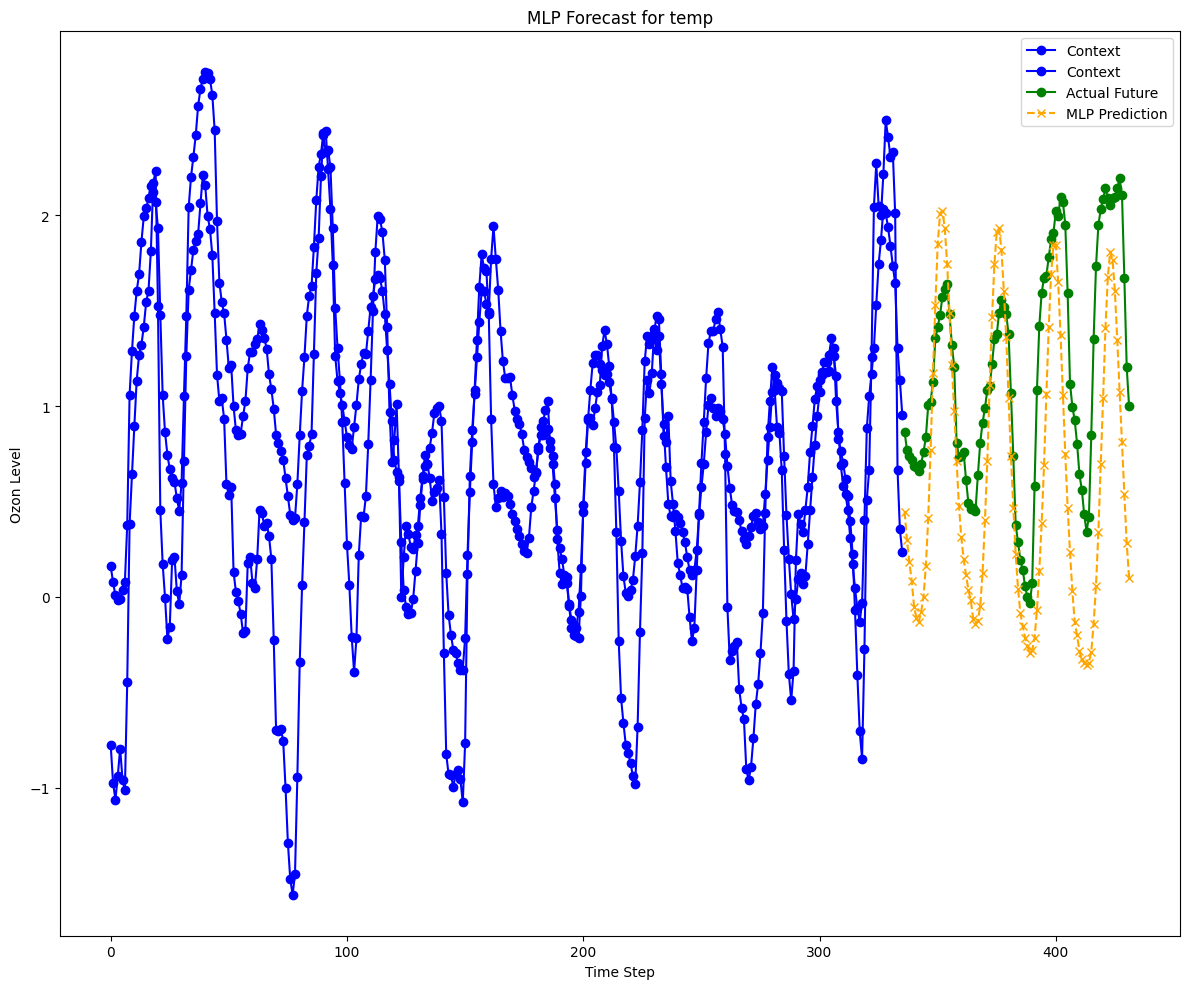

In [110]:
plt.figure(figsize=(12, 10))

for variable_idx in range(num_variables):

    # First sample of DENW094 station to compare with PatchTST
    X_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == 'DENW094')[0]
    #X_test_sample=X_test_full[X_first_idx, :, variable_idx+1] # First column is station code hence adding 1
    X_test_sample = X_test_full[X_first_idx, :, 1:3]  # Spalten 1 und 2: temp + o3
    X_test_sample_flat = X_test_sample.reshape(1, -1).astype(np.float32)
    # First sample of DENW094 station to compare with PatchTST
    y_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == 'DENW094')[0]
    y_test_sample=y_test_full[y_first_idx, :, variable_idx+1] # First column is station code hence adding 1

    # Predict
    mlp_pred_sample = mlp_model.predict(X_test_sample_flat).flatten()


    plt.plot(range(context_window), X_test_sample, label="Context", color="blue", marker="o")
    plt.plot(range(context_window, context_window + prediction_horizon), y_test_sample, label="Actual Future", color="green", marker="o")
    plt.plot(range(context_window, context_window + prediction_horizon), mlp_pred_sample, label="MLP Prediction", linestyle="--", color="orange", marker="x")

    plt.title(f"MLP Forecast for {variable_column[variable_idx]}")
    plt.xlabel("Time Step")
    plt.ylabel("Ozon Level")
    plt.legend()

plt.tight_layout()
plt.show()


# Conclusion

In this nodebook a Multilayer Perceptron (MLP) model is implemented to forecast ozone levels using past time series data with temperature and ozon levels as input features. The model was trained on normalized inputs and evaluated on unseen test samples. One such example is visualized for the DENW094 station, where the model predicted the ozon level based on the last 336 hours (context window). The predicted values (orange) closely follow the trend of the actual future values (green), demonstrating the model's ability to capture temporal dynamics. While some under- and overestimations occur, especially near peaks, the general pattern is preserved. The performance indicates that even a relatively simple feedforward MLP can provide meaningful forecasts on multivariate time series data. Further improvements may be possible using more complex models or feature engineering.